In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 204.2MB 71kB/s 
     |████████████████████████████████| 204kB 23.7MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=9fb83ef82cf414a0706a486207df70435c7d369a2efc8f6e97c7157ea9979c32
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading

In [3]:
# Let's import the libraries we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [4]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [5]:
df_taxi = spark.read.format("csv").option("header", "true").load('/content/drive/MyDrive/home_repo_big_data/2020_Yellow_Taxi_Trip_Data__January_-_June_.csv')
print((df_taxi.count(), len(df_taxi.columns)))

(16847778, 18)


In [6]:
df = df_taxi.withColumn('tpep_pickup_datetime_trim', df_taxi['tpep_pickup_datetime'].substr(1, 10))
print((df.count(), len(df.columns)))

(16847778, 19)


<h2> Trip distance per day v/s covid cases

In [7]:
df = df.withColumn("trip_distance_int", df["trip_distance"].cast('float'))
df.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)
 |-- congestion_surcharge: string (nullable = true)
 |-- tpep_pickup_datetime_trim: string (nullable = true)
 |-- trip_distance_int: float (nullable = true)



In [8]:
df_distance_sum = df.groupBy("tpep_pickup_datetime_trim").sum("trip_distance_int")

In [9]:
df_distance_sum.take(5)

[Row(tpep_pickup_datetime_trim='02/28/2020', sum(trip_distance_int)=749583.5106227212),
 Row(tpep_pickup_datetime_trim='03/22/2020', sum(trip_distance_int)=36497.099980056286),
 Row(tpep_pickup_datetime_trim='04/12/2020', sum(trip_distance_int)=133401.89156166092),
 Row(tpep_pickup_datetime_trim='05/11/2020', sum(trip_distance_int)=263184.88374719955),
 Row(tpep_pickup_datetime_trim='02/11/2020', sum(trip_distance_int)=592990.3598562963)]

In [10]:
df_distance_avg = df.groupBy("tpep_pickup_datetime_trim").mean("trip_distance_int")
# print((df_distance_avg.count(), len(df_distance_avg.columns)))

In [11]:
df_distance_avg.take(5)

[Row(tpep_pickup_datetime_trim='02/28/2020', avg(trip_distance_int)=2.988531658650511),
 Row(tpep_pickup_datetime_trim='03/22/2020', avg(trip_distance_int)=3.5297001914948054),
 Row(tpep_pickup_datetime_trim='04/12/2020', avg(trip_distance_int)=30.099704774742985),
 Row(tpep_pickup_datetime_trim='05/11/2020', avg(trip_distance_int)=22.144289755759324),
 Row(tpep_pickup_datetime_trim='02/11/2020', avg(trip_distance_int)=2.693757738916103)]

In [12]:
# from pyspark.ml.feature import MinMaxScaler
# from pyspark.ml.linalg import Vectors
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml import Pipeline

# assembler = VectorAssembler(inputCols=["sum(trip_distance_int)"], outputCol="sum_vec")
# scaler = MinMaxScaler(inputCol="sum_vec", outputCol="scaled_sum", min=-1.0, max=1.0)
# pipeline = Pipeline(stages=[assembler, scaler])
# scalerModel = pipeline.fit(df_distance_sum)
# df_distance_sum_scaled = scalerModel.transform(df_distance_sum)

In [13]:
# df_distance_sum_scaled_pd = df_distance_sum_scaled.toPandas()
# sum_scaled_arr = df_distance_sum_scaled_pd['scaled_sum']
# sum_scaled = []
# for i in sum_scaled_arr:
#     sum_scaled.append(i[0])
# plt.plot(sum_scaled)

In [14]:
# assembler = VectorAssembler(inputCols=["avg(trip_distance_int)"], outputCol="avg_vec")
# scaler = MinMaxScaler(inputCol="avg_vec", outputCol="scaled_avg", min=-1.0, max=1.0)
# pipeline = Pipeline(stages=[assembler, scaler])
# scalerModel = pipeline.fit(df_distance_avg)
# df_distance_avg_scaled = scalerModel.transform(df_distance_avg)

In [15]:
# df_distance_avg_scaled_pd = df_distance_avg_scaled.toPandas()
# avg_scaled_arr = df_distance_avg_scaled_pd['scaled_avg']
# avg_scaled = []
# for i in avg_scaled_arr:
#     avg_scaled.append(i[0])
# plt.plot(avg_scaled)

In [16]:
df_distance_sum_pd = df_distance_sum.toPandas()
df_distance_sum_pd.head()

df_distance_sum_pd['Date'] = pd.to_datetime(df_distance_sum_pd.tpep_pickup_datetime_trim)
df_distance_sum_pd_sorted = df_distance_sum_pd.sort_values(by = 'Date')
df_distance_sum_pd_sorted = df_distance_sum_pd_sorted[['Date', 'sum(trip_distance_int)']]
df_distance_sum_pd_sorted = df_distance_sum_pd_sorted[5:187]

df_distance_sum_pd_sorted = df_distance_sum_pd_sorted.set_index('Date')
df_distance_sum_pd_sorted.head()

,sum(trip_distance_int)
Date,
2020-01-01,591768.659974
2020-01-02,531202.779947
2020-01-03,545200.129854
2020-01-04,537076.039936
2020-01-05,543166.999883


In [17]:
df_distance_avg_pd = df_distance_avg.toPandas()
df_distance_avg_pd.head()

df_distance_avg_pd = df_distance_avg.toPandas()
df_distance_avg_pd.head()

df_distance_avg_pd['Date'] = pd.to_datetime(df_distance_avg_pd.tpep_pickup_datetime_trim)
df_distance_avg_pd_sorted = df_distance_avg_pd.sort_values(by = 'Date')
df_distance_avg_pd_sorted = df_distance_avg_pd_sorted[['Date', 'avg(trip_distance_int)']]
df_distance_avg_pd_sorted = df_distance_avg_pd_sorted[5:187]

df_distance_avg_pd_sorted = df_distance_avg_pd_sorted.set_index('Date')
df_distance_avg_pd_sorted.head()

,avg(trip_distance_int)
Date,
2020-01-01,3.492559
2020-01-02,3.276178
2020-01-03,2.971490
2020-01-04,2.938824
2020-01-05,3.303956


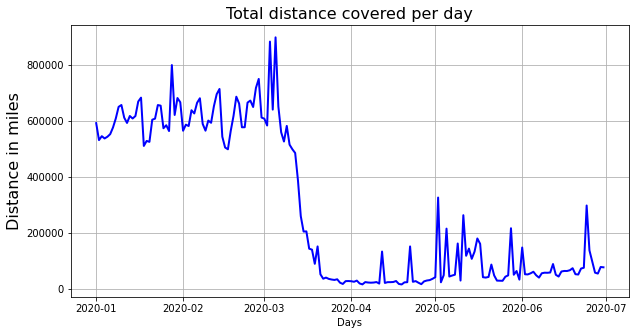

In [20]:
fig = plt.figure(figsize = (10, 5))
plt.plot(df_distance_sum_pd_sorted['sum(trip_distance_int)'], 'blue',linewidth=2)
plt.xlabel("Days")
plt.ylabel("Distance in miles",fontsize=16) 
plt.title("Total distance covered per day",fontsize=16) 
plt.grid()
plt.show() 

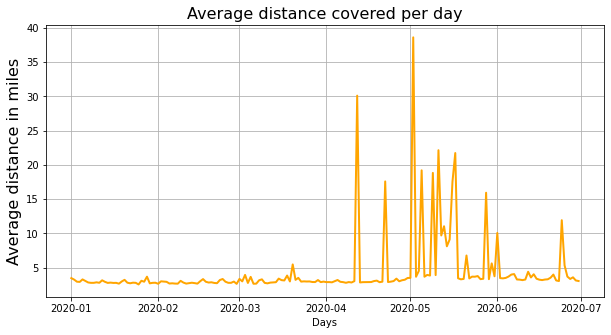

In [21]:
fig = plt.figure(figsize = (10, 5))
plt.plot(df_distance_avg_pd_sorted['avg(trip_distance_int)'], 'orange',linewidth=2)
plt.xlabel("Days")
plt.ylabel("Average distance in miles",fontsize=16) 
plt.title("Average distance covered per day",fontsize=16) 
plt.grid()
plt.show() 

In [25]:
covid_df = pd.read_csv('/content/cleaned_covid19_confirmed_US.csv')
covid_df.shape

(307, 60)

In [26]:
covid_df_req = covid_df[:161]

In [27]:
covid_df_ny = covid_df_req['New York']
covid_df_ny.shape

(161,)

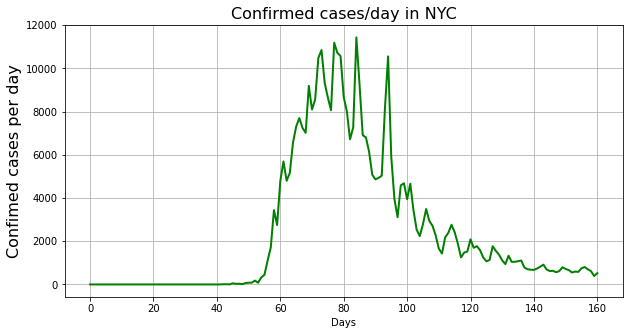

In [29]:
covid_df_ny_diff = covid_df_ny.diff().fillna(covid_df_ny)
fig = plt.figure(figsize = (10, 5))
plt.plot(covid_df_ny_diff, 'green',linewidth=2)
plt.xlabel("Days")
plt.ylabel("Confimed cases per day",fontsize=16) 
plt.title("Confirmed cases/day in NYC",fontsize=16)
plt.grid() 
plt.show() 

<h2>Number of passengers

Distribution of passengers

In [30]:
df = df.withColumn("passenger_count_float", df["passenger_count"].cast('float'))
df.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)
 |-- congestion_surcharge: string (nullable = true)
 |-- tpep_pickup_datetime_trim: string (nullable = true)
 |-- trip_distance_int: float (nullable = true)
 |-- passenger_count_float: float (nullable = true)



In [31]:
df_passenger_count = df.groupBy("passenger_count").count()
# print((df_passenger_count.count(), len(df_passenger_count.columns)))

In [32]:
df_passenger_count.take(15)

[Row(passenger_count='7', count=66),
 Row(passenger_count='3', count=624782),
 Row(passenger_count='8', count=42),
 Row(passenger_count='0', count=330810),
 Row(passenger_count=None, count=280883),
 Row(passenger_count='5', count=563588),
 Row(passenger_count='6', count=338163),
 Row(passenger_count='9', count=39),
 Row(passenger_count='1', count=12025880),
 Row(passenger_count='4', count=296741),
 Row(passenger_count='2', count=2386784)]

In [33]:
df_passenger_count_pd = df_passenger_count.toPandas()

In [34]:
df_passenger_count_pd = df_passenger_count_pd.dropna()

In [35]:
df_passenger_count_pd = df_passenger_count_pd.set_index(['passenger_count'])

In [36]:
df_passenger_count_pd.head(10)

,count
passenger_count,
7,66
3,624782
8,42
0,330810
5,563588
6,338163
9,39
1,12025880
4,296741


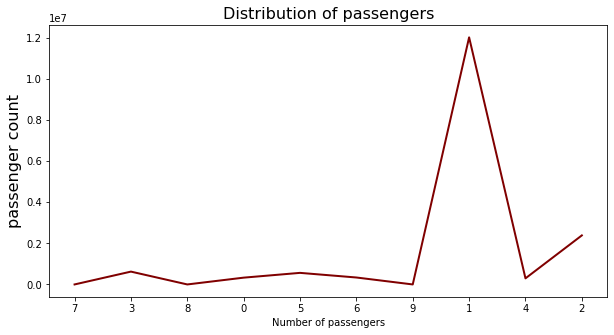

In [40]:
fig = plt.figure(figsize = (10, 5))
plt.plot(df_passenger_count_pd['count'], 'maroon',linewidth=2)
plt.xlabel("Number of passengers")
plt.ylabel("passenger count",fontsize=16) 
plt.title("Distribution of passengers",fontsize=16) 
plt.show() 

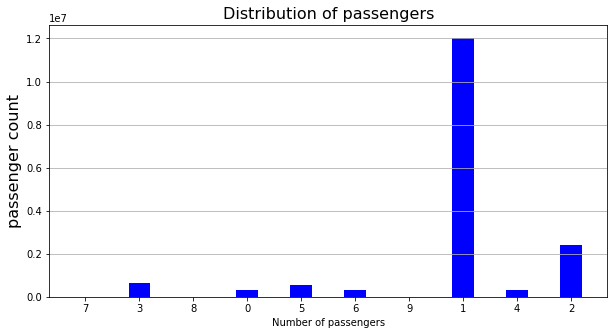

In [39]:
fig = plt.figure(figsize = (10, 5)) 
plt.bar(df_passenger_count_pd.index, df_passenger_count_pd['count'], color ='blue', width = 0.4) 
  
plt.xlabel("Number of passengers")
plt.ylabel("passenger count",fontsize=16) 
plt.title("Distribution of passengers",fontsize=16) 
axes = plt.gca()
axes.yaxis.grid()
plt.show() 

Sum of passenger counts

In [41]:
df_pc_sum = df.groupBy("tpep_pickup_datetime_trim").sum("passenger_count_float")
# print((df_pc_sum.count(), len(df_pc_sum.columns)))

In [42]:
df_pc_pd = df_pc_sum.toPandas()
df_pc_pd.head()

df_pc_pd['Date'] = pd.to_datetime(df_pc_pd.tpep_pickup_datetime_trim)
df_pc_pd_sorted = df_pc_pd.sort_values(by = 'Date')
df_pc_pd_sorted = df_pc_pd_sorted[['Date', 'sum(passenger_count_float)']]
df_pc_pd_sorted = df_pc_pd_sorted[5:187]

df_pc_pd_sorted = df_pc_pd_sorted.set_index('Date')
df_pc_pd_sorted.head()

,sum(passenger_count_float)
Date,
2020-01-01,281825.0
2020-01-02,253419.0
2020-01-03,285181.0
2020-01-04,295810.0
2020-01-05,258618.0


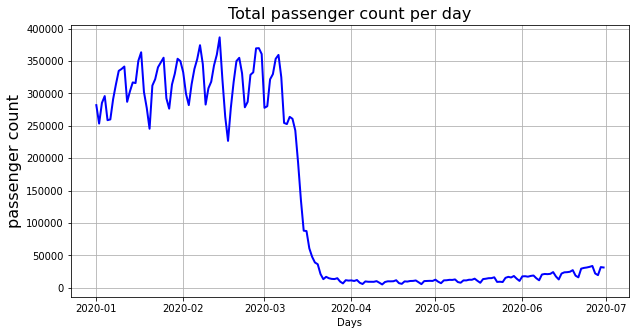

In [43]:
fig = plt.figure(figsize = (10, 5))
plt.plot(df_pc_pd_sorted['sum(passenger_count_float)'], 'blue',linewidth=2)
plt.xlabel("Days")
plt.ylabel("passenger count",fontsize=16) 
plt.title("Total passenger count per day",fontsize=16) 
plt.grid()
plt.show() 

Average of passenger count


In [44]:
df_pc_avg = df.groupBy("tpep_pickup_datetime_trim").avg("passenger_count_float")

In [45]:
df_pc_pd_avg = df_pc_avg.toPandas()
df_pc_pd_avg.head()

df_pc_pd_avg['Date'] = pd.to_datetime(df_pc_pd_avg.tpep_pickup_datetime_trim)
df_pc_pd_sorted_avg = df_pc_pd_avg.sort_values(by = 'Date')
df_pc_pd_sorted_avg = df_pc_pd_sorted_avg[['Date', 'avg(passenger_count_float)']]
df_pc_pd_sorted_avg = df_pc_pd_sorted_avg[5:187]

df_pc_pd_sorted_avg = df_pc_pd_sorted_avg.set_index('Date')
df_pc_pd_sorted_avg.head()

,avg(passenger_count_float)
Date,
2020-01-01,1.671778
2020-01-02,1.580993
2020-01-03,1.571072
2020-01-04,1.627959
2020-01-05,1.586244


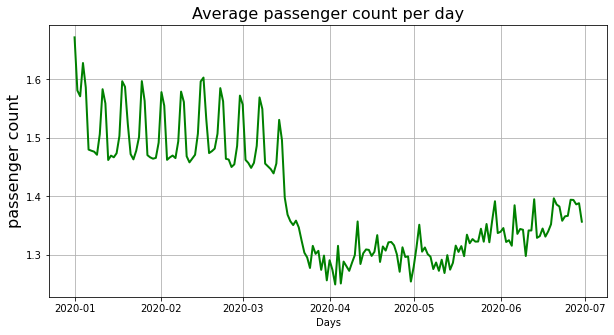

In [47]:
fig = plt.figure(figsize = (10, 5))
plt.plot(df_pc_pd_sorted_avg['avg(passenger_count_float)'], 'green',linewidth=2)
plt.xlabel("Days")
plt.ylabel("passenger count",fontsize=16) 
plt.title("Average passenger count per day",fontsize=16)
plt.grid() 
plt.show() 

Number of Trips per day

Sum of Trips

In [48]:
df_trips_sum = df.groupBy("tpep_pickup_datetime_trim").count()

In [49]:
df_trips_pd = df_trips_sum.toPandas()
df_trips_pd.head()

df_trips_pd['Date'] = pd.to_datetime(df_trips_pd.tpep_pickup_datetime_trim)
df_trips_pd_sorted = df_trips_pd.sort_values(by = 'Date')
df_trips_pd_sorted = df_trips_pd_sorted[['Date', 'count']]
df_trips_pd_sorted = df_trips_pd_sorted[5:187]

df_trips_pd_sorted = df_trips_pd_sorted.set_index('Date')
df_trips_pd_sorted.head()

,count
Date,
2020-01-01,169437
2020-01-02,162141
2020-01-03,183477
2020-01-04,182752
2020-01-05,164399


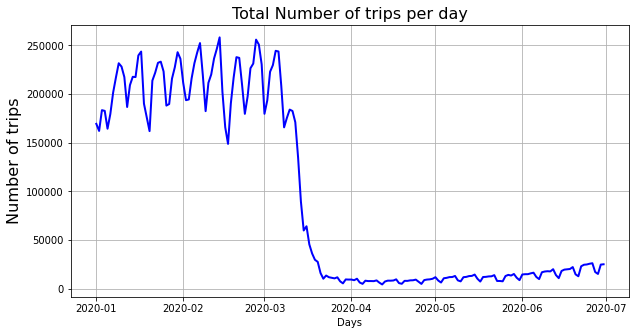

In [50]:
fig = plt.figure(figsize = (10, 5))
plt.plot(df_trips_pd_sorted['count'], 'blue',linewidth=2)
plt.xlabel("Days")
plt.ylabel("Number of trips",fontsize=16) 
plt.title("Total Number of trips per day",fontsize=16) 
plt.grid()
plt.show() 

Total amount per day

In [51]:
df = df.withColumn("total_amount_float", df["total_amount"].cast('float'))
df.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)
 |-- congestion_surcharge: string (nullable = true)
 |-- tpep_pickup_datetime_trim: string (nullable = true)
 |-- trip_distance_int: float (nullable = true)
 |-- passenger_count_float: float (nullable = true)
 |-- total_amount_float

In [52]:
df_amount_sum = df.groupBy("tpep_pickup_datetime_trim").sum("total_amount_float")

In [53]:
df_amount_pd = df_amount_sum.toPandas()
df_amount_pd.head()

df_amount_pd['Date'] = pd.to_datetime(df_amount_pd.tpep_pickup_datetime_trim)
df_amount_pd_sorted = df_amount_pd.sort_values(by = 'Date')
df_amount_pd_sorted = df_amount_pd_sorted[['Date', 'sum(total_amount_float)']]
df_amount_pd_sorted = df_amount_pd_sorted[5:187]

df_amount_pd_sorted = df_amount_pd_sorted.set_index('Date')
df_amount_pd_sorted.head()

,sum(total_amount_float)
Date,
2020-01-01,3.339325e+06
2020-01-02,3.156269e+06
2020-01-03,3.396079e+06
2020-01-04,3.275097e+06
2020-01-05,3.130069e+06


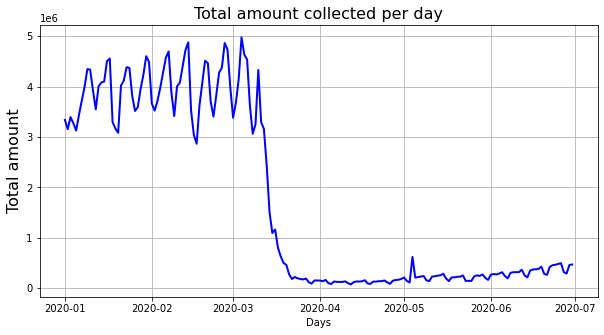

In [54]:
fig = plt.figure(figsize = (10, 5))
plt.plot(df_amount_pd_sorted['sum(total_amount_float)'], 'blue',linewidth=2)
plt.xlabel("Days")
plt.ylabel("Total amount",fontsize=16) 
plt.title("Total amount collected per day",fontsize=16) 
plt.grid()
plt.show() 

Average amount per day

In [55]:
df_amount_avg = df.groupBy("tpep_pickup_datetime_trim").avg("total_amount_float")

In [56]:
df_amount_pd_avg = df_amount_avg.toPandas()
df_amount_pd_avg.head()

df_amount_pd_avg['Date'] = pd.to_datetime(df_amount_pd_avg.tpep_pickup_datetime_trim)
df_amount_pd_sorted_avg = df_amount_pd_avg.sort_values(by = 'Date')
df_amount_pd_sorted_avg = df_amount_pd_sorted_avg[['Date', 'avg(total_amount_float)']]
df_amount_pd_sorted_avg = df_amount_pd_sorted_avg[5:187]

df_amount_pd_sorted_avg = df_amount_pd_sorted_avg.set_index('Date')
df_amount_pd_sorted_avg.head()

,avg(total_amount_float)
Date,
2020-01-01,19.708359
2020-01-02,19.466199
2020-01-03,18.509565
2020-01-04,17.920994
2020-01-05,19.039467


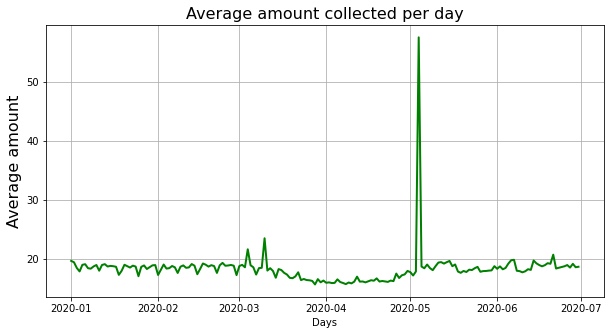

In [57]:
fig = plt.figure(figsize = (10, 5))
plt.plot(df_amount_pd_sorted_avg['avg(total_amount_float)'], 'green',linewidth=2)
plt.xlabel("Days")
plt.ylabel("Average amount",fontsize=16) 
plt.title("Average amount collected per day",fontsize=16) 
plt.grid()
plt.show() 